## 1. Loading and normalizing CIFAR10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import argparse
import numpy as np


## 1. Data Preparation

In [2]:
# transforms.ToTensor() : 이미지 파일로 저장된 것을 torch의 Tensor로 읽고 변환해줌
# transforms.Normalize((r,g,b),(r,g,b)) : 각각의 이미지 tensor들을 normalize함. r,g,b 채널에 대해서 하기 위해 3개의 값이 들어있음
# ex) (0.5, 0.5, 0.5) -> 첫 번째 0.5 : 모든 pixel의 red값은 0.5를 빼겠다 / standard deviation을 0.5로 잡은 것임. 즉, normalize를 각 채널별로 해줌
# -> 평균이 0.5이고 standard deviation이 0.5인 normal distribution으로 바꿈
# 일반적으로 rgb 값은 0~255까지의 값이지만 ToTensor()을 하면 0~1까지의 값으로 스케일링 됨 / 0 : 제일 어두움, 1 : 제일 밝음
transform = transforms.Compose(
    [transforms.ToTensor(), # shape (H x W x C) -> (C x H x W) 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_set, val_set = torch.utils.data.random_split(train_set, [40000, 10000])
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=4, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=False, num_workers=2)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
len(test_set)

10000

In [4]:
train_set[0][0]

tensor([[[-0.4431, -0.1922, -0.0745,  ..., -0.1843, -0.5059, -0.6941],
         [-0.4980, -0.3961, -0.0980,  ..., -0.2392, -0.7333, -0.7333],
         [-0.3647, -0.5137, -0.2627,  ..., -0.2941, -0.6941, -0.7647],
         ...,
         [-0.4667, -0.3647, -0.3569,  ...,  0.0118, -0.0275, -0.0588],
         [-0.4039, -0.4039, -0.4275,  ...,  0.3333,  0.3020,  0.2078],
         [-0.4667, -0.4510, -0.4431,  ...,  0.2078,  0.2157,  0.1608]],

        [[-0.3882, -0.1451, -0.0275,  ..., -0.1686, -0.4824, -0.6706],
         [-0.4588, -0.3569, -0.0588,  ..., -0.2314, -0.7098, -0.7098],
         [-0.3412, -0.4902, -0.2392,  ..., -0.2784, -0.6784, -0.7412],
         ...,
         [-0.4431, -0.3725, -0.3333,  ...,  0.0196, -0.0196, -0.0588],
         [-0.3882, -0.3961, -0.3804,  ...,  0.3412,  0.3098,  0.2078],
         [-0.4745, -0.4588, -0.4196,  ...,  0.2157,  0.2235,  0.1686]],

        [[-0.4118, -0.1608, -0.0431,  ..., -0.1686, -0.5451, -0.7569],
         [-0.4667, -0.3647, -0.0588,  ..., -0

### Inspecting Dataset

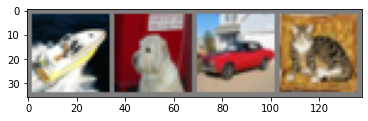

 ship   dog   car   cat


In [5]:
import matplotlib.pyplot as plt

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5                         # unnormalize 
    npimg = img.numpy()                         # numpy로만 바뀌었을뿐 이미지임 / numpy로 바꾸는 이유 : matplotlib이 numpy랑 친함 
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # (1, 2, 0) : 원하는 순열을 차원의 index 값으로 지정 / transpose를 하는 이유 : numpy.ndarray는 (H x W x C) 순서대로 이미지를 표현한다
    plt.show()
    
# get some random training images
dataiter = iter(train_loader)                   # 4개씩 묶인 전체 train_loader를 그냥 iter하게 만든 것뿐
images, labels = dataiter.next()                # batch 한 묶음이 나옴(4개)

# show images
imshow(torchvision.utils.make_grid(images))     # grid 격자 형태로 여러 개의 image가 보임 (C, H, W*4)
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4))) 
# ground-truth : 우리가 정한 정답, 모델이 우리가 원하는 답으로 예측해주길 바라는 답  / cf) label : 답이 명확하게 정해져 있는 값

In [6]:
print(iter(train_loader).next()[0].shape)  # image size
print(iter(train_loader).next()[1].shape)  # label size

torch.Size([4, 3, 32, 32])
torch.Size([4])


In [7]:
# type, shape 확인
print(type(images), images.shape) 
# torch.Size([4, 3, 32, 32]) -> [batch_size, rgb, width, height]
# 즉, 32*32*3 = 3072 차원이 input x가 됨

print(type(labels), labels.shape, labels)

<class 'torch.Tensor'> torch.Size([4, 3, 32, 32])
<class 'torch.Tensor'> torch.Size([4]) tensor([8, 5, 1, 3])


## 2. Define a MLP Architecture


In [8]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act):  # n_layer : hidden layer을 원하는 개수만큼 만들기 위해 지정
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act
        
        self.fc = nn.Linear(self.in_dim, self.hid_dim)
        self.linears = nn.ModuleList()                                  # ModuleList에 hidden layer 개수만큼 만들어서 넣어줌
        
        for i in range(self.n_layer-1):                                 # 맨 마지막 layer은 밖에서 다시 만들어 줄 것임
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))  # 이 안에 있는 hidden layer들은 계속 같은 hid_dim으로 학습함
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)
        
        if self.act == 'relu':                                          # relu말고 다른 function이 들어올 수 있어서 if 절로 제한
            self.act = nn.ReLU()
            
    def forward(self, x):         # input x :(4, 3072) / x의 shape (batch, in_dim) 즉, (4, 3*32*32)
        x = self.act(self.fc(x))  # (3072, 100) / 주로 fc랑 act는 한 layer로 구분하기 편하게 한 줄로 작성함 / 이 layer를 통과한 전체 x의 사이즈 : (4,100)
        for fc in self.linears:   # fc에 바로 nn.linears object까지 반환됨
            x = self.act(fc(x))   # self.fc와 이 fc는 다른 것임!
                                  # 마지막 layer에 relu를 씌우면 0으로 truncate 되기 때문에 classification할 때 문제가 발생할 수 있어서 activation을 빼줘야 함
        x = self.fc2(x)           # activation이 없기 때문에 바로 실숫값 범위에서 값이 나옴
        return x
    
net = MLP(3072, 10, 100, 2, 'relu')
print(net)

MLP(
  (fc): Linear(in_features=3072, out_features=100, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (act): ReLU()
)


## 3. Define a Loss function and Optimizer

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

print(criterion)
print(optimizer)

CrossEntropyLoss()
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


## 4. Train the network

In [10]:
# =====Train===== #
for epoch in range(2):  # loop over the dataset multiple times
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):  # train_loader = 50,000 % 4 = 12,500 # Q. enumerate에 뒤에 0은 왜 쓴 거지? i가 0부터 시작
        # get the inputs
        inputs, labels = data                   # inputs size : [4, 3, 32, 32]
        inputs = inputs.view(-1, 3072)          # inputs size : [4, 3072] / [샘플의 개수, x의 전체 dimension] / 순서가 중요하고, 아예 축 위치를 바꾸고 싶다면 torch.swapaxes 사용
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)                   # net(inputs)를 하면 net.__call__(inputs)를 하는 것과 동일함 / __call__ : 이거는 nn.Module에 정의되어 있고, forward 함수를 불러오는 역할
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
print('Finished Training')

[1,  2000] loss: 1.936
[1,  4000] loss: 1.742
[1,  6000] loss: 1.676
[1,  8000] loss: 1.636
[1, 10000] loss: 1.572
[2,  2000] loss: 1.510
[2,  4000] loss: 1.514
[2,  6000] loss: 1.484
[2,  8000] loss: 1.510
[2, 10000] loss: 1.464
Finished Training


## 5. Test the network on the test data

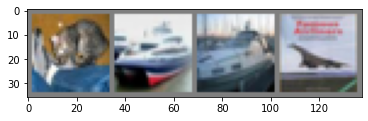

GroundTruth:    cat  ship  ship plane


In [11]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [12]:
# =====Measure Test Accuracy===== # 
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data                          # labels : tensor([3, 8, 8, 0])
        images = images.view(-1, 3072)
        outputs = net(images)

        _, predicted = torch.max(outputs, 1)           # outputs.data[0] : [0.6796,  0.6472,  0.0345,  1.0080, -0.3824,  0.2668,  0.1370, -1.8479, 0.8098, -0.3629] -> 이게 배치 값만큼 존재
                                                       # predicted : tensor([3, 9, 8, 8])
        total += labels.size(0)                        # 4 / 배치 사이즈인 4를 가져옴. len(labels)나 len(outputs)를 해도 됨
        correct += (predicted == labels).sum().item()  # (predicted == labels)가 tensor of boolean이기 때문에 sum이 가능
    
    test_acc = 100 * correct / total
          
print('Accuracy of the network on the 10000 test images: {}%'.format(test_acc))

Accuracy of the network on the 10000 test images: 47.39%


In [13]:
a = torch.tensor([3, 9, 8, 8])
b = torch.tensor([3, 8, 0, 8])
print(a==b)
print((a==b).sum())

tensor([ True, False, False,  True])
tensor(2)


## 6. Test the network on the validation data

In [14]:
# =====Measure Val Accuracy / Val Loss===== #
correct = 0
total = 0
val_loss = 0

with torch.no_grad():
    for data in val_loader:
        images, labels = data 
        images = images.view(-1, 3072)
        outputs = net(images)
        
        loss = criterion(outputs, labels)  # 각 batch에 대한 loss
        val_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1) 
        total += labels.size(0) 
        correct += (predicted == labels).sum().item() 

    # 전체 val set 에 대한 loss
    val_loss = val_loss / len(val_loader)
    acc = 100 * correct / total
print('Accuracy of the network on the 10000 test images: {:2.2f}% Loss: {:2.2f}'.format(acc, val_loss))

Accuracy of the network on the 10000 test images: 46.99% Loss: 1.47


## 7. Experiment


In [15]:
def experiment(args):
    net = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act)
    # net.cuda() # GPU가 가능한 경우 사용
    print(net)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=args.mm)
    
    
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        
        # =====Train===== #
        running_loss = 0.0
        train_loss = 0.0 
        for i, data in enumerate(train_loader, 0): 
            # get the inputs
            inputs, labels = data        
            inputs = inputs.view(-1, 3072)
            # inputs = inputs.cuda()
            # labels = labels.cuda()
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = net(inputs)  
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # print statistics
            running_loss += loss.item()
            train_loss += loss.item()  # epoch 단위로 train loss를 구하기 위해 저장
            if i % 2000 == 1999:       # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
                
        # =====Validation===== #
        correct = 0
        total = 0
        val_loss = 0

        with torch.no_grad():
            for data in val_loader:
                images, labels = data 
                images = images.view(-1, 3072)
                # images = images.cuda()
                # labels = labels.cuda()
                outputs = net(images)
                
                loss = criterion(outputs, labels)  # 각 batch에 대한 loss
                val_loss += loss.item()            # item으로 통용을 해놨기 때문에 이걸 다시 cpu로 넘길 필요가 없음

                _, predicted = torch.max(outputs.data, 1) 
                total += labels.size(0) 
                correct += (predicted == labels).sum().item() 

            # 전체 val set 에 대한 loss
            val_loss = val_loss / len(val_loader)
            val_acc = 100 * correct / total
            
            print('Epoch: {}, Train Loss: {}, Val Loss: {}, Val Acc: {}'.format(epoch, train_loss, val_loss, val_acc))
            
    # =====Evaluation===== #
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data 
            images = images.view(-1, 3072)
            # images = images.cuda()
            # labels = labels.cuda()
            outputs = net(images)

            _, predicted = torch.max(outputs.data, 1)                                                       
            total += labels.size(0)                    
            correct += (predicted == labels).sum().item() 
        
        test_acc = 100 * correct / total
            
        
    return train_loss, val_loss, val_acc, test_acc

In [16]:
seed = 123  # 같은 지점에서 starting point를 만들어줌
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")

args.n_layer = 5
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'
args.lr = 0.001
args.mm = 0.9

args.epoch = 2

list_var1 = [4, 5, 6]
list_var2 = [50, 100, 150]

for var1 in list_var1:
    for var2 in list_var2:
        args.n_layer = var1
        args.hid_dim = var2
        result = experiment(args)
        print(result)

MLP(
  (fc): Linear(in_features=3072, out_features=50, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
  )
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (act): ReLU()
)
[1,  2000] loss: 2.181
[1,  4000] loss: 1.895
[1,  6000] loss: 1.787
[1,  8000] loss: 1.754
[1, 10000] loss: 1.693
Epoch: 0, Train Loss: 18620.754895061255, Val Loss: 1.6556199220776557, Val Acc: 40.77
[2,  2000] loss: 1.616
[2,  4000] loss: 1.621
[2,  6000] loss: 1.613
[2,  8000] loss: 1.588
[2, 10000] loss: 1.587
Epoch: 1, Train Loss: 16052.347110807896, Val Loss: 1.5394791520237923, Val Acc: 45.16
(16052.347110807896, 1.5394791520237923, 45.16, 44.7)
MLP(
  (fc): Linear(in_features=3072, out_features=100, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Linear(in_features=100, ou